`seaborn`, a Python data visualization library built on top of `matplotlib`, offers a convenient and powerful interface for creating visually appealing and informative statistical graphics. It works very well with macro-quantamental data In this notebook, we showcase how you to create histograms for multiple indicators or cross-sections, examine indicator ranges, perform timeline analysis, explore bivariate relationships (including OLS, logistic, and locally weighted regressions), and utilize color maps.

# Prerequisites

In [1]:
# !pip install macrosynergy

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from timeit import default_timer as timer
from datetime import timedelta, date

from macrosynergy.download import JPMaQSDownload

import warnings
warnings.simplefilter('ignore')

Next, we define cross-sectional identifiers for potentially relevant countries or currency areas. These are the basis for forming data panels (sets of comparable time series) across markets.

Most cross-section identifiers refer to currencies, currency areas, or - in the case of Euro area countries - economic areas. The currency names are in alphabetical order: AUD (Australian dollar), BRL (Brazilian real), CAD (Canadian dollar), CHF (Swiss franc), CLP (Chilean peso), CNY (Chinese yuan renminbi), COP (Colombian peso), CZK (Czech Republic koruna), DEM (German mark), ESP (Spanish peseta), EUR (euro), FRF (French franc), GBP (British pound), HKD (Hong Kong dollar), HUF (Hungarian forint), IDR (Indonesian rupiah), ILS (Israeli shekel), INR (Indian rupee), ITL (Italian lira), JPY (Japanese yen), KRW (Korean won), MXN (Mexican peso), MYR (Malaysian ringgit), NLG (Dutch guilder), NOK (Norwegian krone), NZD (New Zealand dollar), PEN (Peruvian sol), PHP (Philippine peso), PLN (Polish zloty), RON (Romanian leu), RUB (Russian ruble), SEK (Swedish krona), SGD (Singaporean dollar), THB (Thai baht), TRY (Turkish lira), TWD (Taiwanese dollar), USD (U.S. dollar), ZAR (South African rand).

In [3]:
cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = [
    "CLP",
    "COP",
    "CZK",
    "HUF",
    "IDR",
    "ILS",
    "INR",
    "KRW",
    "MXN",
    "PLN",
    "THB",
    "TRY",
    "TWD",
    "ZAR",
]
cids = cids_dm + cids_em

Next, we set the indicator categories that we want to download (here for all available markets). We can also download only specific tickers or a small subset of cross-sections. In JPMaQS indicators are organized in panels, i.e. time series of the same category are available for a range of cross-sections (countries or markets). The concatenation of cross-section and category is called "ticker".

There are various metrics that can be downloaded for each ticker, including publication lags and quality grades. However, for this notebook, we focus only on `value, i.e. the value of the ticker as it was available to the market at (end of) the date at which is recorded. 

In [4]:
ecos = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "PCREDITGDP_SJA_D1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
    "PCREDITBN_SJA_P1M1ML12",
]
mkts = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10",
    "FXCRR_NSA",
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]

xcats = ecos + mkts

In [5]:
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dfd = pd.read_csv('fixed-income-returns-and-macro-trends/JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])

./76551.xlsx
./Corporate bond.pdf
./desktop.ini
./introduction-to-macrosynergy-package.ipynb
./jpmaqs-with-seaborn.ipynb
./operationDataPoint.pdf
./operationDataPoint2.pdf
./operationDataPoint3.pdf
./operationDataPoint4.pdf
./operationDataPoint5.pdf
./operationDataPoint6.pdf
./Part1.mp4
./Part3.mp4
./Wage growth.ipynb
./fixed-income-returns-and-macro-trends\JPMaQS_Quantamental_Indicators.csv
./New folder\1710061653539.pdf
./New folder\5Social_SetMenu2023.pdf
./New folder\A statistical analysis of log periodic precursors to financial crashes.pdf
./New folder\Credit Oriented Fixed Income .pptx
./New folder\Currency Hedge or Unhedge NEWRevised.pptx
./New folder\Factor Based Performance Attribution (002).pdf
./New folder\GMT20230930-125543_Recording_640x360.mp4
./New folder\GMT20231007-124544_Recording_1920x1080.mp4
./New folder\GMT20231014-130109_Recording_1790x956.mp4
./New folder\GMXB presentation.pdf
./New folder\Income Fund_(Roadshow)_PPT.pdf
./New folder\INTRODUCTION TO QUANTITATIVE 

This notebook uses JPMaQS standard free [dataset](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends) available on Kaggle

In [6]:
# It is often helpful to append a ticker column as a concatenation of cid and xcat. This shortens the code for references to individual time series (as opposed to panels).
dfd['ticker'] = dfd['cid'] + "_" + dfd["xcat"]
dfd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3350271 entries, 0 to 3350270
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   value      float64       
 4   grading    float64       
 5   eop_lag    float64       
 6   mop_lag    float64       
 7   ticker     object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 230.0+ MB


# Historical distributions of indicators

## Histograms for single indicators

A histogram provides a simplified visualization of the past empirical distribution. It shows the size of bins that fall into certain value ranges rather than actual values. In `seaborn` the `sns.histplot()` has replaced the older `sns.distplot` method.
Conveniently, it comes with a kernel density estimate overlay option, which can be exercised by setting the `kde` argument to "True".

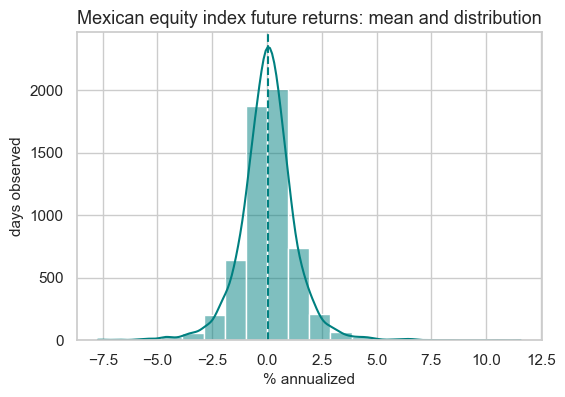

In [7]:
dfx = dfd[dfd['real_date'] >= pd.to_datetime('2000-01-01')]  # set start date
dfw = dfx.pivot_table(index='real_date', columns='ticker', values='value').replace(0, np.nan)  # bring df to wide format
var = 'MXN_EQXR_NSA'  # specified indicator to analyze

col='teal'
sns.set_theme(style='whitegrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
sns.histplot(x = var, data=dfw, bins=20, kde=True, color=col)  # histogram with custom bin number and kde overlay
plt.axvline(x= np.mean(dfw[var]), color=col, linestyle='--')  # add vertical line for mean

plt.title('Mexican equity index future returns: mean and distribution', fontsize=13)  # add chart title
plt.xlabel('% annualized', fontsize=11)  # overwrite standard x-axis label
plt.ylabel('days observed', fontsize=11)  # overwrite standrad y-axis label
plt.show()

The `sns.histplot()` method can customize the width of the bins with the `binwidth` argument. One can also, change the units of the y-axis with the `stat` argument from 'count' to 'frequency' (number of observations divided by the bin width),  'density' (normalizes counts so that the area of the histogram is 1), or 'probability' (normalizes counts so that the sum of the bar heights is 1).

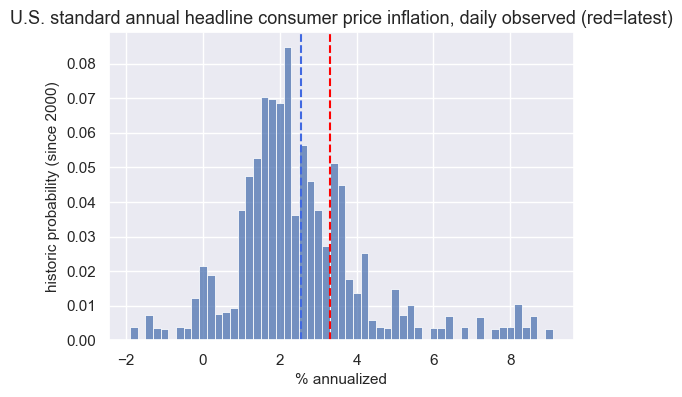

In [8]:
dfx = dfd[dfd['real_date'] >= pd.to_datetime('2000-01-01')]  # set start date
dfw = dfx.pivot(index='real_date', columns='ticker', values='value').replace(0, np.nan)  # bring df to wide format
var = 'USD_CPIH_SA_P1M1ML12'  # specified indicator to analyze

col='royalblue'
sns.set_theme(style='darkgrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
sns.histplot(x = var, data=dfw, binwidth=0.2, stat = 'probability')  # histogram pre-set bin-width and probability bars
plt.axvline(x= np.mean(dfw[var]), color=col, linestyle='--')  # add vertical line for mean
plt.axvline(x= dfw[var].dropna().iloc[-1], color='red', linestyle='--')  # add line for latest

plt.title('U.S. standard annual headline consumer price inflation, daily observed (red=latest)', fontsize=13)  # add chart title
plt.xlabel('% annualized', fontsize=11)  # overwrite standard x-axis label
plt.ylabel('historic probability (since 2000)', fontsize=11)  # overwrite standrad y-axis label
plt.show()

## Histograms for multiple indicators

The `hue` argument allows displaying multiple counts or probabilities in one plot. This can serve two principal purposes. 
1. We can compare the distribution of the values of cross-sections. For this purpose, we choose the setting `multiple='layer`, which plots overlapping histograms. We can visualize the contribution of various series or cross-sections to a joint histogram, by setting `multiple='stacked'`.

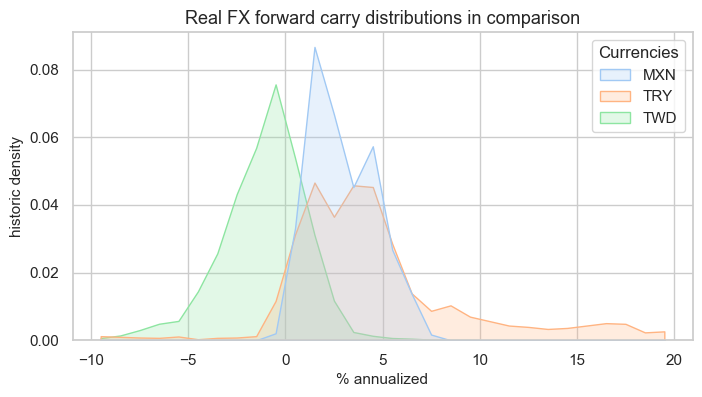

In [9]:
cids_sel = ['TWD', 'MXN', 'TRY']  # select small group of cross-sections
filt1 = dfd['xcat'] == 'FXCRR_NSA'  # choose (filter out) category
filt2 = dfd['cid'].isin(cids_sel)  # choose cross-sections
filt3 = dfd['real_date'] >= pd.to_datetime('2010-01-01')  # set start date
dfx = dfd[filt1 & filt2 & filt3][['value', 'cid']].replace(0, np.nan)  # dataframe in appropriate format

colors = 'pastel'  # choose color palette
sns.set_theme(style='whitegrid', rc={'figure.figsize':(8, 4)})  #  choose appearance
ax = sns.histplot(x='value', data=dfx,  
             hue='cid', element='poly', multiple='layer',  # use hue and polygons for overlapping cross-sections
             binrange=(-10, 20), binwidth = 1, stat='density', palette=colors)
plt.title('Real FX forward carry distributions in comparison', fontsize=13)  # set title
plt.xlabel('% annualized', fontsize=11)  # set x-axis label
plt.ylabel('historic density', fontsize=11)  # set y-axis label
leg = ax.axes.get_legend()  # add legend box to plot to identify cross-sections
leg.set_title('Currencies')  # give title to legend box
plt.show()

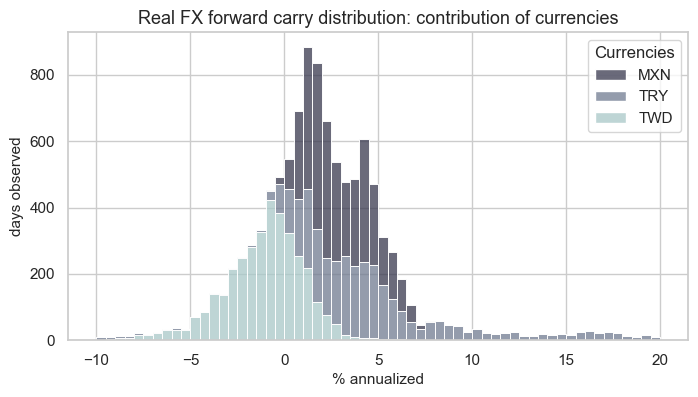

In [10]:
cids_sel = ['MXN', 'TRY', 'TWD']  # select a small group of cross-sections
filt1 = dfd['cid'].isin(cids_sel)  # filter out cross-sections
filt2 = dfd['xcat'] == 'FXCRR_NSA'  # filter out category
filt3 = dfd['real_date'] >= pd.to_datetime('2010-01-01')  # set start date
dfx = dfd[filt1 & filt2 & filt3][['value', 'cid']].sort_values('cid')  # dataframe in appropriate format

colors = 'bone'  # choose color palette
sns.set_theme(style='whitegrid', rc={'figure.figsize':(8, 4)})  #  choose appearance
ax = sns.histplot(x='value', data=dfx,  
             hue='cid', element='bars', multiple='stack',  # use hue and bars/stack for overlapping visualization
             binrange=(-10, 20), binwidth = 0.5, stat='count', palette=colors)

plt.title('Real FX forward carry distribution: contribution of currencies', fontsize=13)  # set title
plt.xlabel('% annualized', fontsize=11)  # set x-axis label
plt.ylabel('days observed', fontsize=11)  # set y-axis label
leg = ax.axes.get_legend()  # add legend box to plot to identify cross-sections
leg.set_title('Currencies')  # give title to legend box
plt.show()

For a larger number of cross-sections or two-dimensional segmentation a facet grid created by the `sns.displot()` function is typically preferable.

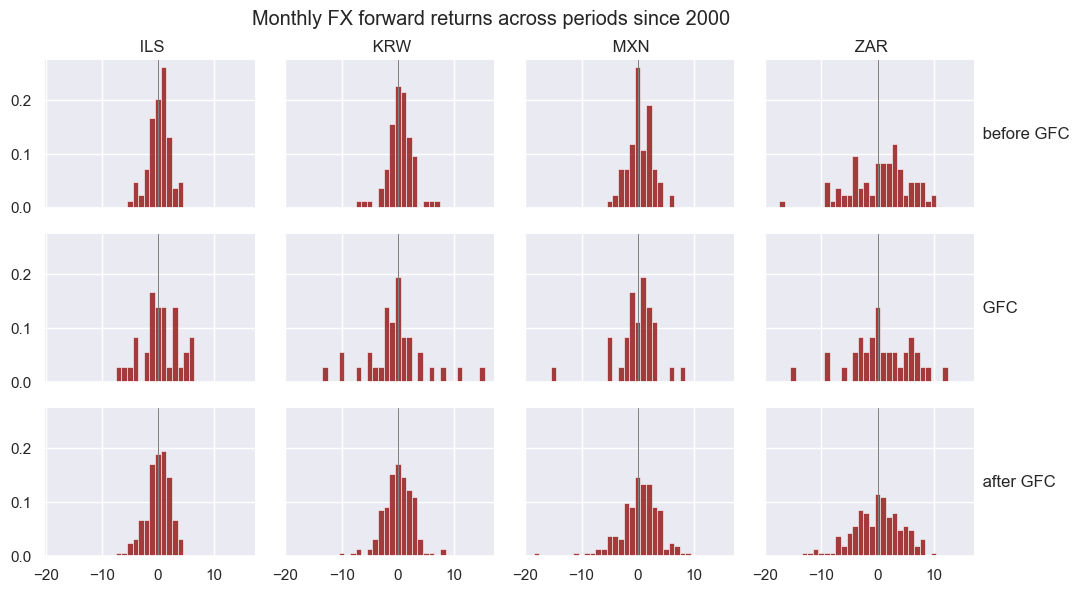

In [11]:
cids_sel = ['BRL', 'MXN', 'ILS', 'ZAR', 'KRW']  # select a small group of cross-sections
filt1 = dfd['cid'].isin(cids_sel)  # filter out cross-sections
filt2 = dfd['xcat'] == 'FXXR_NSA'  # filter out category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # set start date
dfx = dfd[filt1 & filt2 & filt3][['real_date', 'cid', 'value']].sort_values(['cid', 'real_date'])  # dataframe in appropriate format
dfm = dfx.groupby(['cid']).resample('M', on='real_date').sum(numeric_only="True")['value'].reset_index()  # convert to monthly

dfm['period'] = 'before GFC'  # create custom categorical variable
dfm.loc[dfm['real_date'].dt.year > 2006, 'period'] = 'GFC'
dfm.loc[dfm['real_date'].dt.year > 2009, 'period'] = 'after GFC'

sns.set_theme(style='darkgrid')  #  choose appearance
fg = sns.displot(dfm, x="value", col="cid", row="period",
                 kind='hist', stat='density', binwidth=1, color='darkred', # specify histplot as basis for distributions
                 common_norm=False,  # passthrough for histplot() to secure independent normalization across subsets
                 height=2, aspect=1.3,  # control size and shape
                 facet_kws=dict(margin_titles=True))

fg.map(plt.axvline, x=0, c=".5", lw=0.75)  # map horizontal zero line to each chart in grid
fg.set_axis_labels('', '')  # set axes labels of individual charts
fg.fig.suptitle('Monthly FX forward returns across periods since 2000', y=1.02)  # set facet grid title

for ax in fg.axes.flat:  # modify top and right axes titles
    if ax.get_title():  # check for axes title text
        ax.set_title(ax.get_title().split('=')[1])  # remove unwanted standard text  
    if ax.texts:  # check for right ylabel text        
        txt = ax.texts[0]
        ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                txt.get_text().split('=')[1], transform=ax.transAxes, va='center')   # remove unwanted standard text 
        ax.texts[0].remove()   # remove original text

plt.show()

### Multi-indicator distribution graphs

The boxplot is a **condensed categorical distribution plot**, which means it is particularly suitable for visualizing a few selected key distribution features across categories. In `seaborn` this type of plot is managed by the `sns.boxplot()` method. The distributional features can be applied for one or multiple categories across a full range of cross-sections.

The **boxes** in these plots mark the <u>thresholds of the 25% and 75% percentiles</u> (inner quartile range) on the outer edges and the median in the centre. The **whiskers** are the ranges obtained by picking the largest or smallest data points respectively within range defined by <u>stretching the inner quartile range 1.5 times above or below the median</u>. Points outside this range are considered outliers.

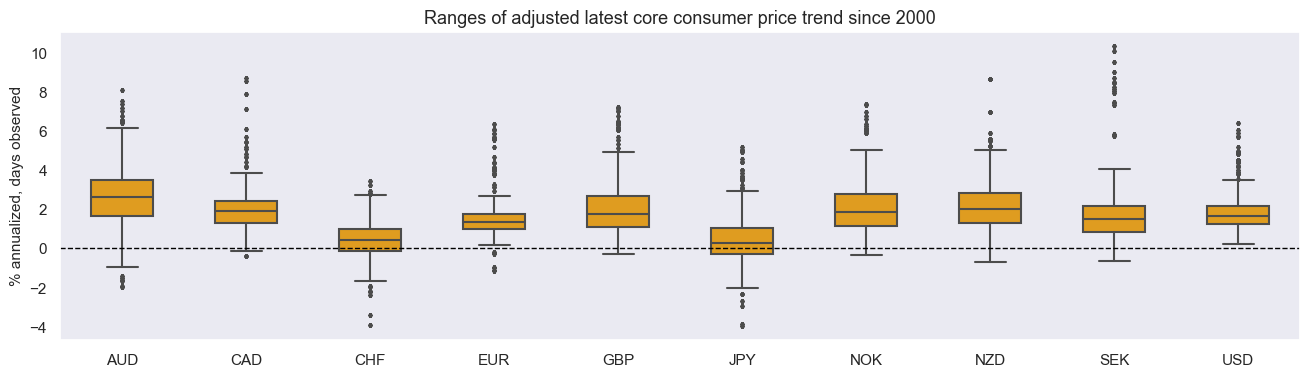

In [12]:
cids_sel = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # select cross-sections
filt1 = dfd['cid'].isin(cids_sel)  #  filter out cross-sections
filt2 = dfd['xcat'] == 'CPIC_SJA_P3M3ML3AR'  #  filter out category

dfx = dfd[filt1 & filt2][['value', 'cid', 'xcat']].sort_values('cid')  # dataframe in appropriate format 

color='orange'
sns.set_theme(style='dark', rc={'figure.figsize':(16, 4)})  #  choose appearance
ax = sns.boxplot(data=dfx, x='cid', y='value', color=color, width=0.5, fliersize=2)  # single category box-whiskers

plt.axhline(y=0, color='black', linestyle='--', lw=1)  # horizontal line at zero
plt.title('Ranges of adjusted latest core consumer price trend since 2000', fontsize=13)  # set title
plt.xlabel('')  # set x-axis label
plt.ylabel('% annualized, days observed', fontsize=11)  # set y-axis label
plt.show()

Multiple categories for each cross-section can be plotted by using the `hue` argument and setting it to the column name that is used for categorization.

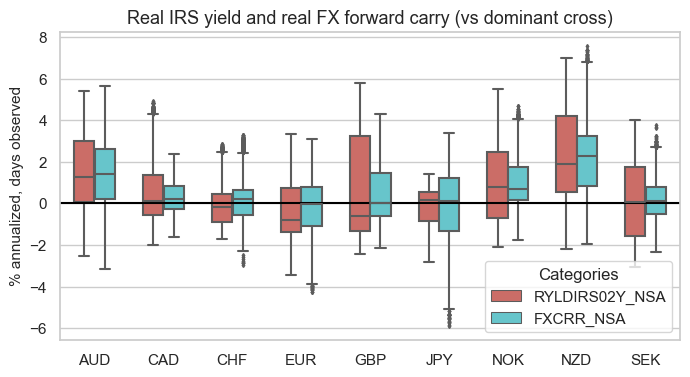

In [13]:
cids_sel = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK']  # select cross-sections
xcats_sel = ['RYLDIRS02Y_NSA', 'FXCRR_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter out cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  # select category
dfx = dfd[filt1 & filt2][['value', 'cid', 'xcat']].sort_values('cid')  # dataframe in appropriate format 

colors='hls'  # choose color palette
sns.set_theme(style='whitegrid', rc={'figure.figsize':(8, 4)})  #  choose appearance
ax = sns.boxplot(data=dfx, x='cid', y='value', hue='xcat',  # hue allows subcategories
                 palette=colors, width=0.6, fliersize=2)

plt.title('Real IRS yield and real FX forward carry (vs dominant cross)', fontsize=13)  # set title
plt.axhline(y=0, color='black', linestyle='-', lw=1.5)  # horizontal line at zero
plt.xlabel('')  # set x-axis label
plt.ylabel('% annualized, days observed', fontsize=11)  # set y-axis label
leg = ax.axes.get_legend()  # add legend box explicitly for control
leg.set_title('Categories')  # set title of legend box
plt.show()

A **violin plot** is a categorical distribution plot that is a combination of boxplot and (mostly) symmetric KDE plot. Like the boxplot it displays medians and inner quartile ranges. However, unlike a boxplot, it does not focus on outliers but rather on the shape of the probability distribution function. The outer shape represents all possible results. The inner shape represents the distribution of the inner 95% of all values observed.
In `seaborn`, violin plots are managed through the `sns.violinplot()` method.

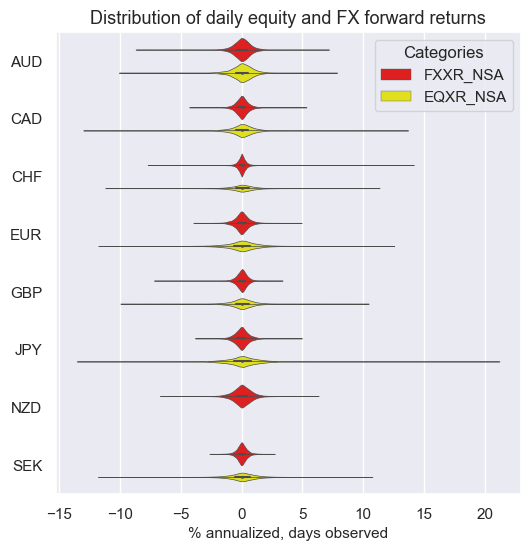

In [14]:
cids_sel = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NZD', 'SEK']  # select cross-sections
xcats_sel = ['EQXR_NSA', 'FXXR_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter out cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  # select category
dfx = dfd[filt1 & filt2][['value', 'cid', 'xcat']].sort_values('cid')  # dataframe in appropriate format 

colors= ['red', 'yellow']  # choose color palette
sns.set_theme(style='darkgrid', rc={'figure.figsize':(6, 6)})  #  choose appearance
ax = sns.violinplot(data=dfx, y='cid', x='value', hue='xcat',  # hue visualizes multiple categories
                    palette=colors, linewidth=0.5)  # appearance of the violins

plt.title('Distribution of daily equity and FX forward returns', fontsize=13)  # set title
plt.ylabel('')  # set x-axis label
plt.xlabel('% annualized, days observed', fontsize=11)  # set y-axis label
leg = ax.axes.get_legend()  # add legend box explicitly for control
leg.set_title('Categories')  # set title of legend box
plt.show()

The **boxenplot** is similar to the boxplot, but plots more quantiles and thus contains more detailed information.

In `seaborn` this type of plot is governed by the `sns.boxenplot()` method.

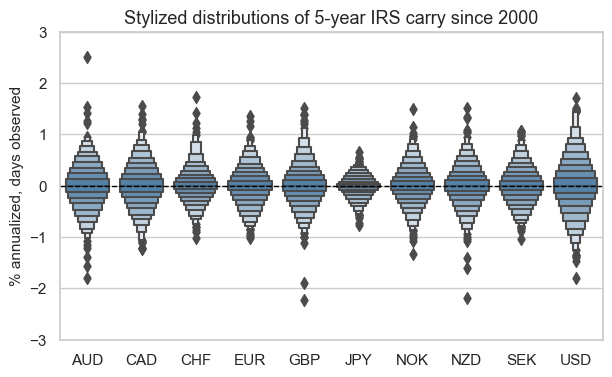

In [15]:
cids_sel = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # select cross-sections
filt1 = dfd['cid'].isin(cids_sel)  #  filter out cross-sections
filt2 = dfd['xcat'] == 'DU05YXR_NSA'  #  filter out category

dfx = dfd[filt1 & filt2][['value', 'cid', 'xcat']].sort_values('cid')  

color='steelblue'
sns.set_theme(style='whitegrid', rc={'figure.figsize':(7, 4)})  #  choose appearance
ax = sns.boxenplot(data=dfx, x='cid', y='value', color=color, scale='linear')  # single category box-whiskers
ax.set_ylim([-3, 3])
plt.axhline(y=0, color='black', linestyle='--', lw=1)  # horizontal line at zero
plt.title('Stylized distributions of 5-year IRS carry since 2000', fontsize=13)  # set title
plt.xlabel('')  # set x-axis label
plt.ylabel('% annualized, days observed', fontsize=11)  # set y-axis label
plt.show()

# Timelines of indicators

### Lineplots

The purpose of a `lineplot` is two illustrate a continuous relationship between two variables, where time is typically one of these variables. In `seaborn` the method to manage `lineplot`s is `sns.lineplot()`. Its most simple application is to pass to it a wide dataframe with a time axis as rows and individual series as columns.

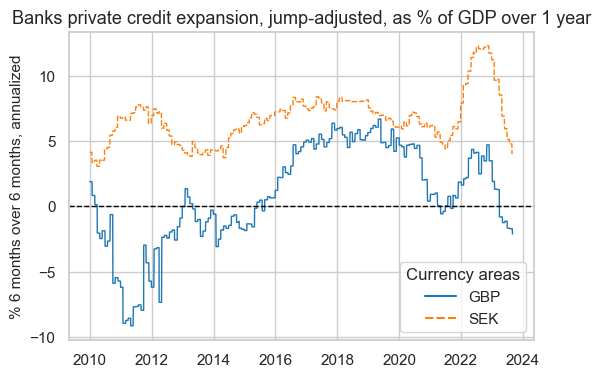

In [16]:
cids_sel = ['GBP', 'SEK']  # select cross-sections
filt1 = dfd['cid'].isin(cids_sel)  # filter out cross-sections
filt2 = dfd['xcat'] == 'PCREDITGDP_SJA_D1M1ML12'  # filter out category
filt3 = dfd['real_date'] >= pd.to_datetime('2010-01-01')  # set start date
dfx = dfd[filt1 & filt2 & filt3]
dfw = dfx.pivot(index=['real_date'], columns='cid', values='value')  # pivot data frame to common time scale

colors='tab10'  # choose color palette
sns.set_theme(style='whitegrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
ax = sns.lineplot(data=dfw, estimator=None, palette=colors, linewidth=1)  # simply pass data frame with time scale to method

plt.axhline(y=0, color='black', linestyle='--', lw=1)  # horizontal line at zero
plt.title('Banks private credit expansion, jump-adjusted, as % of GDP over 1 year', fontsize=13)  # set title
plt.xlabel('')  # set x-axis label
plt.ylabel('% 6 months over 6 months, annualized', fontsize=11)  # set y-axis label

leg = ax.axes.get_legend()  # add legend box explicitly for control
leg.set_title('Currency areas')  # set title of legend box

plt.show()

Importantly, the `seaborn` `lineplot` method does not simply plot a line, but can also estimate a confidence interval using **bootstrapping**. The method creates many samples by selecting uniformly and with replacement from the observed values that were actually reported at a given point in time. The default is to create 1000 samples and to create aggregates - typically the mean - from each of these samples. The 95% confidence interval denotes the lower and upper boundary of the inner 95% aggregate values that were created.

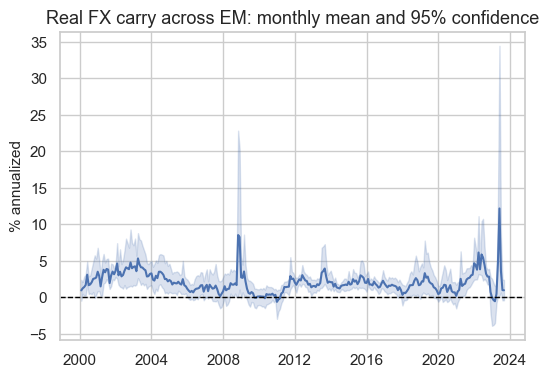

In [17]:
cids_sel = cids_em  # select cross-sections
xcat_sel = 'FXCRR_NSA'  # select category
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'] == xcat_sel  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dfm = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').mean()['value'].reset_index()  # convert to monthly averages
dfw = dfm.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to appropriate index

colors='Paired'  # choose color palette
sns.set_theme(style='whitegrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
sns.lineplot(data=dfw, x='real_date', y=xcat_sel, estimator='mean', ci=95)  # plot mean and its 95% confidence interval

plt.axhline(y=0, color='black', linestyle='--', lw=1)  # horizontal line at zero
plt.title('Real FX carry across EM: monthly mean and 95% confidence', fontsize=13)  # set title
plt.xlabel('')  # set x-axis label
plt.ylabel('% annualized', fontsize=11)  # set y-axis label

plt.show()

The `seaborn` `lineplot` can not only display values chronologically but also aggregate information over time units, such as months. This may reveal seasonal patterns. The confidence interval can be set with the `ci` argument. If high confidence intervals for many underlying observations do not overlap and reveal a clear patter, seasonality is likely.

With the 'hue' argument one can also compare confidence intervals across categories.

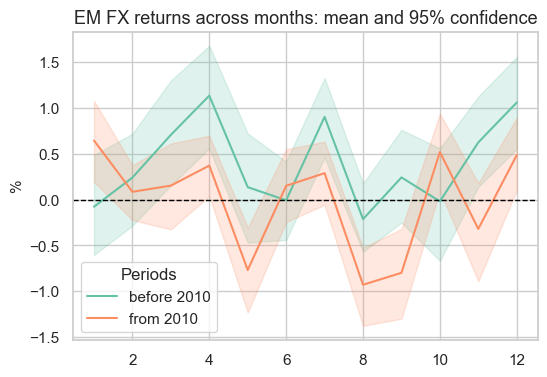

In [18]:
cids_sel = cids_em  # select cross-sections
xcat_sel = 'FXXR_NSA'  # select category
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'] == xcat_sel  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame

dfm = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').sum()['value'].reset_index()  # monthly means
dfw = dfm.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()
dfw['month'] = dfw['real_date'].dt.month
dfw['period'] = 'before 2010'
dfw.loc[dfw['real_date'].dt.year > 2010, 'period'] = 'from 2010'

colors='Set2'  # choose color palette
sns.set_theme(style='whitegrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
ax = sns.lineplot(data=dfw, x='month', y=xcat_sel, hue='period',  # draw different lines for classes of period category
                  estimator='mean', ci=95, palette=colors)  # plot tighter confidence interval

plt.axhline(y=0, color='black', linestyle='--', lw=1)  # horizontal line at zero
plt.title('EM FX returns across months: mean and 95% confidence', fontsize=13)  # set title
plt.xlabel('')  # set x-axis label
plt.ylabel('%', fontsize=11)  # set y-axis label
leg = ax.axes.get_legend()  # add legend box explicitly for control
leg.set_title('Periods')  # set title of legend box

plt.show()

### Line facets

The purpose of facet grids is the creation of small multiples. The class `sns.FacetGrid()` maps a dataset onto multiple axes arrayed in a grid of rows and columns that correspond to levels of variables in the dataset.

The `map()` method of the `FacetGrid` object applies a plotting function to each facet’s subset of the data. The `map_dataframe()` method of the `FacetGrid` is similar to map, but gives more flexibility because it passes arguments inserts data in `kwargs`.

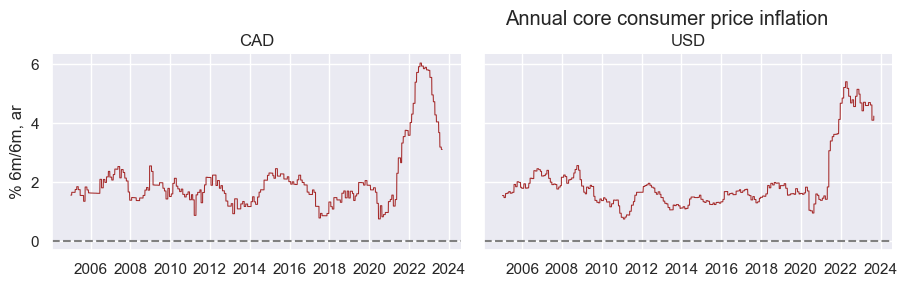

NameError: name 'registrants' is not defined

In [19]:
cids_sel =  ['CAD', 'USD', 'CNY'] # cids_dm['AUD', 'CAD', 'CHF', 'GBP', 'NZD', 'SEK']  # select cross-sections
xcat_sel = 'CPIC_SA_P1M1ML12'  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'] == xcat_sel  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2005-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame

color='brown'  # choose color palette
sns.set_theme(style='darkgrid')  #  choose appearance
fg = sns.FacetGrid(dfx, col='cid', col_wrap=3,  # set number of columns of the grid
                   height=3, aspect=1.5,  # set height and aspect ratio of cheach chart
                   sharey=True)  # gives same y axis to all grid plots
fg.map_dataframe(sns.lineplot, x='real_date', y='value', ci=None, lw=0.75, color=color)  # map `lineplot` to the grid
fg.map(plt.axhline, y=0, c="0.5", lw=1.5, linestyle='--')  # map horizontal zero line to each chart in grid

fg.set_axis_labels('', '% 6m/6m, ar')  # set axes labels of individual charts
fg.set_titles(col_template='{col_name}')  # set individual charts' title
fg.fig.suptitle('Annual core consumer price inflation', y=1.02)  # set facet grid title 
plt.show()
registrants

To display multiple categories in a facet grid of `lineplot`s one manages the categories to be used by setting the `hue` argument in the `lineplot` method to the column that contains the categories.

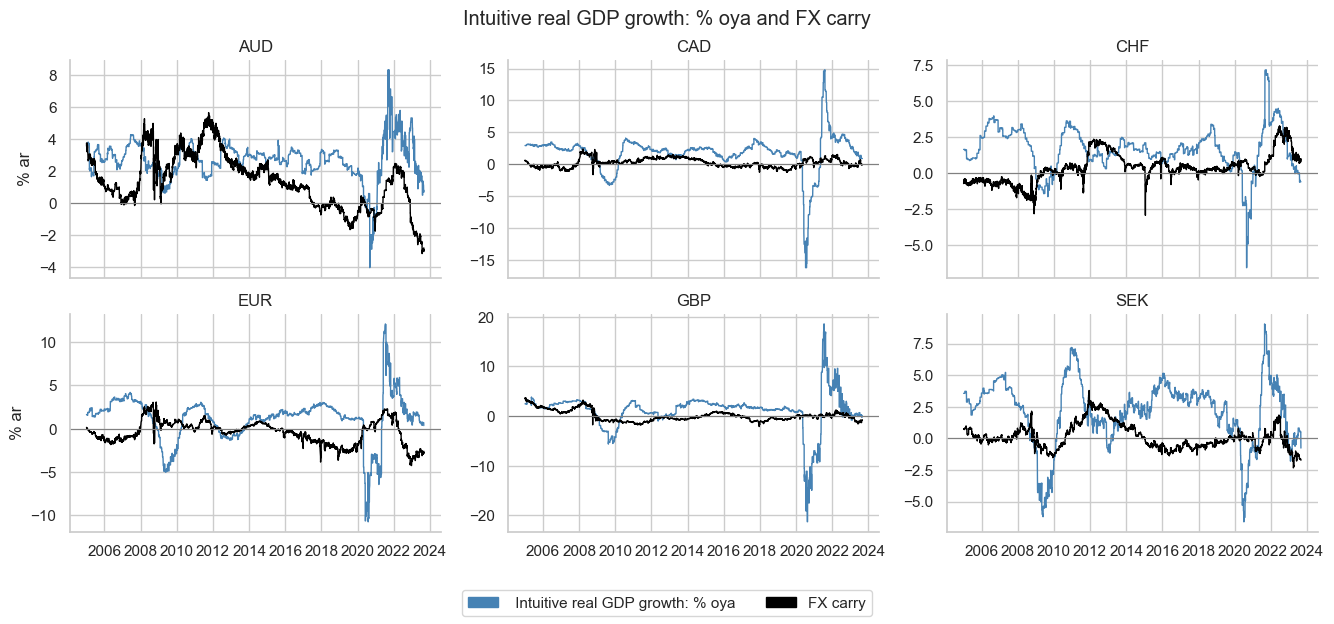

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'SEK']  # select cross-sections
xcats_sel = ['INTRGDP_NSA_P1M1ML12_3MMA', 'FXCRR_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2005-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame

colors=['steelblue', 'black']  # choose color palette
sns.set_theme(style='whitegrid', palette=colors)  #  choose appearance
fg = sns.FacetGrid(dfx, col='cid', col_wrap=3,  # set number of columns of the grid
                   palette=colors, hue='xcat', hue_order=xcats_sel,  # hue is typically defined at the level of the facet grird
                   height=3, aspect=1.5,  # set height and aspect ratio of cheach chart
                   sharey=False)  # gives individual y axes to grid plots
fg.map_dataframe(sns.lineplot, x='real_date', y='value', ci=None, lw=1)  # map `lineplot` to the grid
fg.map(plt.axhline, y=0, c=".5", lw=0.75)  # map horizontal zero line to each chart in grid

fg.set_axis_labels('', '% ar')  # set axes labels of individual charts
fg.set_titles(col_template='{col_name}')  # set individual charts' title
fg.fig.suptitle('Intuitive real GDP growth: % oya and FX carry', y=1.02)  # set facet grid title 

name_to_color = {' Intuitive real GDP growth: % oya': colors[0], 'FX carry': colors[1]}  # assignement dictionary for legend
patches = [mpl.patches.Patch(color=v, label=k) for k,v in name_to_color.items()]  # legend requires patch (due to bug)
labels = name_to_color.keys() # series labels for legend box
fg.fig.legend(handles=patches, labels=labels, loc='lower center', ncol=3)  # add legend to bottom of figure

fg.fig.subplots_adjust(bottom=0.15) # lift bottom so it does not conflict with legend
plt.show()

# Bivariate relations

### Scatterplots

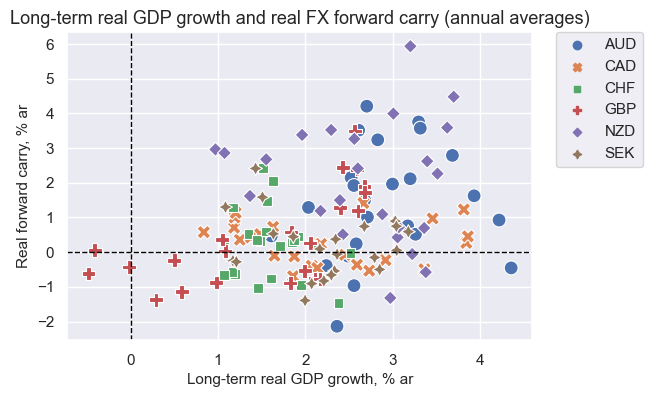

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'GBP', 'NZD', 'SEK']  # select cross-sections
xcats_sel = ['RGDP_SA_P1Q1QL4_20QMA', 'FXCRR_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dfax = dfx.groupby(['cid', 'xcat']).resample('A', on='real_date').mean()['value'].reset_index()  # annual averages
dfaw = dfax.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

colors='deep'  # choose color palette
sns.set_theme(style='darkgrid', palette=colors, rc={'figure.figsize':(6, 4)})  #  choose appearance
ax = sns.scatterplot(x=xcats_sel[0], y=xcats_sel[1], data=dfaw,  # column names used for scatter
                     hue='cid', style='cid',  # distinguishes cids by color and marker
                     s=100)  # controls size of dots

plt.axhline(y=0, color='black', linestyle='--', lw=1)  # horizontal zero line
plt.axvline(x=0, color='black', linestyle='--', lw=1)  # vertical zero line

plt.title('Long-term real GDP growth and real FX forward carry (annual averages)', fontsize=13)  # set title
plt.xlabel('Long-term real GDP growth, % ar', fontsize=11)  # set x-axis label
plt.ylabel('Real forward carry, % ar', fontsize=11)  # set y-axis label
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  # place legend outside box

plt.show()

If the scatter has many points the `alpha` argument allows visualizing density through color intensity.

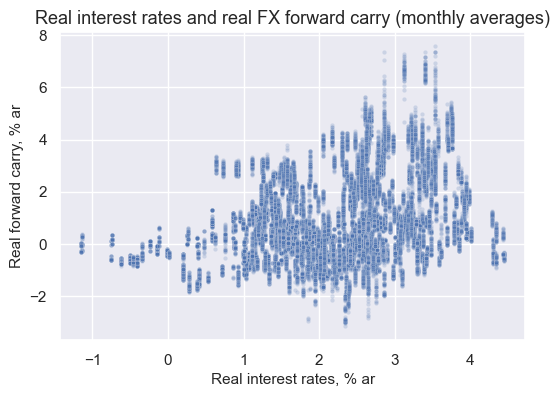

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'GBP', 'NZD', 'SEK']  # select cross-sections
xcats_sel = ['RGDP_SA_P1Q1QL4_20QMA', 'FXCRR_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross 


filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dfw = dfx.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()
  

colors='deep'  # choose color palette
sns.set_theme(style='darkgrid', palette=colors, rc={'figure.figsize':(6, 4)})  #  choose appearance
ax = sns.scatterplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw,  # column names used for scatter
                     alpha=0.2,  # control color intensity and transparency
                     s=10)  # controls size of dots
    
plt.title('Real interest rates and real FX forward carry (monthly averages)', fontsize=13)  # set title
plt.xlabel('Real interest rates, % ar', fontsize=11)  # set x-axis label
plt.ylabel('Real forward carry, % ar', fontsize=11)  # set y-axis label

plt.show()

### Regression plots

The `sns.regplot()` method can plot scatters and a fitted regression line at the same time. Various regression estimators are available.

The shaded bands around the regression line are confidence intervals that were created by bootstrapping. The option `robust = True` stipulates robust regression. This will de-weight outliers but takes significantly more computation time. Using this option makes it advisable to reduce the bootstrap samples with `n_boot`.

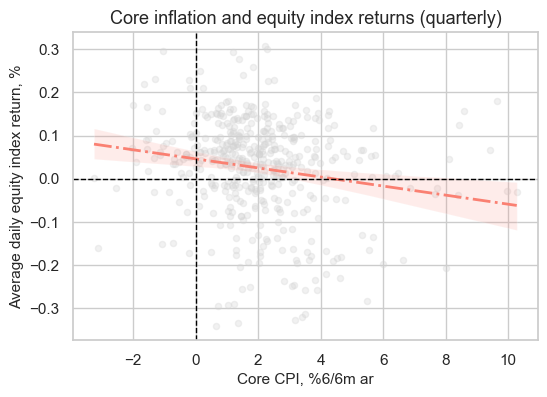

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'GBP', 'NZD', 'SEK']  # select cross-sections
xcats_sel = ['CPIH_SJA_P3M3ML3AR', 'EQXR_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('Q', on='real_date').mean()['value'].reset_index()  # weekly averages
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

sns.set_theme(style='whitegrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
sns.regplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw, ci=98, order=1, 
            robust=False,  #  can use statsmodels' rboust regression method, but takes more time
            scatter_kws={'s': 20, 'alpha': 0.3, 'color':'lightgray'},  # customize appearance of scatter
            line_kws={'lw' : 2, 'linestyle': '-.', 'color': 'salmon'})  # customize appearance of line

plt.axhline(y=0, color='black', linestyle='--', lw=1)  # horizontal zero line
plt.axvline(x=0, color='black', linestyle='--', lw=1)  # vertical zero line

plt.title('Core inflation and equity index returns (quarterly)', fontsize=13)  # set title
plt.xlabel('Core CPI, %6/6m ar', fontsize=11)  # set x-axis label
plt.ylabel('Average daily equity index return, %', fontsize=11)  # set y-axis label

plt.show()

It is possible to visualize **polynomial regression** curves with the `order` argument.

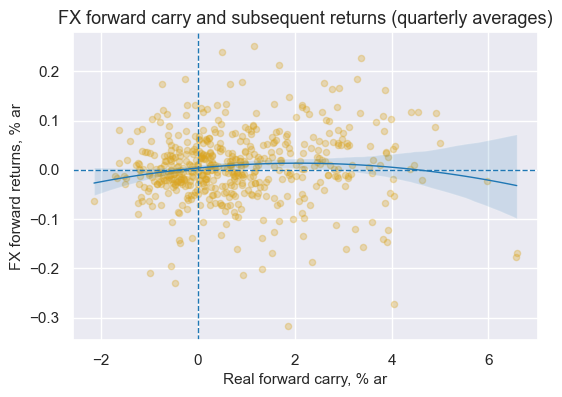

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'GBP', 'NZD', 'SEK']  # select cross-sections
xcats_sel = ['FXCRR_NSA', 'FXXR_NSA']  # select explanatory/dependent categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('Q', on='real_date').mean()['value'].reset_index()  # monthly averages
filt4 = dff['xcat']==xcats_sel[0]  # filter for explanatory data in frequency-transformed dataframe
dff.loc[filt4, 'value'] = dff[filt4].groupby(['cid', 'xcat'])['value'].shift(1)  # lag explanatory values by 1 time period
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

sns.set_theme(style='darkgrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
sns.regplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw, ci=95,  
            order=2,  #  2nd-order polynomial fit
            scatter_kws={'s': 20, 'alpha': 0.3, 'color':'goldenrod'},  # customize appearance of scatter
            line_kws={'lw' : 1, 'linestyle': '-', 'color': 'tab:blue'})  # customize appearance of line

plt.axhline(y=0, color='tab:blue', linestyle='--', lw=1)  # horizontal zero line
plt.axvline(x=0, color='tab:blue', linestyle='--', lw=1)  # vertical zero line

plt.title('FX forward carry and subsequent returns (quarterly averages)', fontsize=13)  # set title
plt.xlabel('Real forward carry, % ar', fontsize=11)  # set x-axis label
plt.ylabel('FX forward returns, % ar', fontsize=11)  # set y-axis label

plt.show()

Other options include `logistic` (for binary dependent) and `lowess` for locally weighted linear regression.

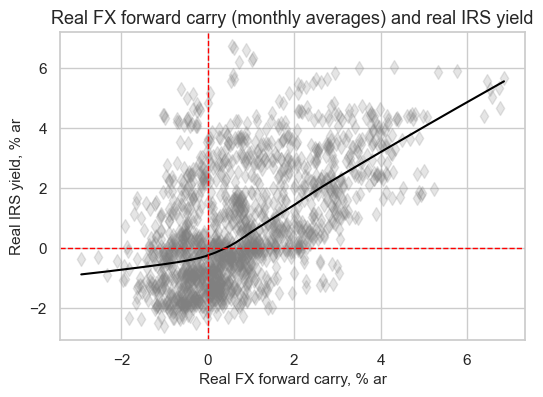

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'GBP', 'NZD', 'SEK']  # select cross-sections
xcats_sel = ['FXCRR_NSA', 'RYLDIRS02Y_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').mean()['value'].reset_index()  # weekly averages
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

sns.set_theme(style='whitegrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
sns.regplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw,  # pass the date
            lowess=True,  #  uses statsmodels to estimate a nonparametric locally weighted linear regression
            marker='d',  # choose diamon market
            scatter_kws={'s': 50, 'alpha': 0.2, 'color':'gray'},  # customize appearance of scatter
            line_kws={'lw' : 1.5, 'color': 'black'})  # customize appearance of line

plt.axhline(y=0, color='red', linestyle='--', lw=1)  # horizontal zero line
plt.axvline(x=0, color='red', linestyle='--', lw=1)  # vertical zero line

plt.title('Real FX forward carry (monthly averages) and real IRS yield', fontsize=13)  # set title
plt.xlabel('Real FX forward carry, % ar', fontsize=11)  # set x-axis label
plt.ylabel('Real IRS yield, % ar', fontsize=11)  # set y-axis label

plt.show()

### Linear model plots

Linear model plots are created with the `sns.lmplot()` method. They visualize linear model data, similar to the `sns.regplot()` method, but are more convenient for distinguishing relations across categories. In particular, linear model plots allow visualizing one type of relation across categories through color codes and also give access to the facet grids, which allows creating small multiples of regplots with just one line of code. 

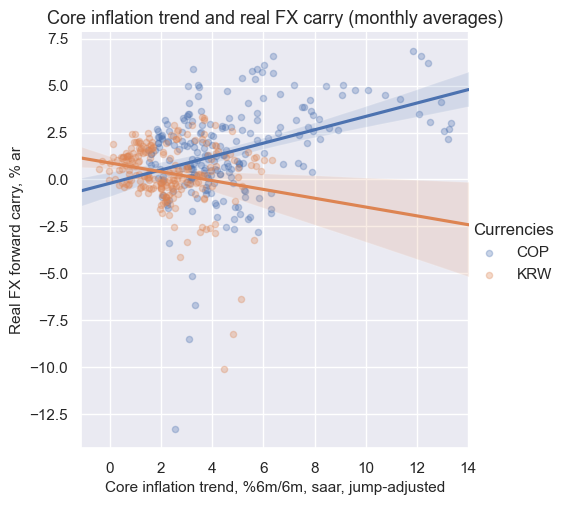

In [ ]:
cids_sel = ['COP', 'KRW']  # select cross-sections
xcats_sel = ['CPIH_SA_P1M1ML12', 'FXCRR_NSA']  # select explanatory/dependent categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2005-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').mean()['value'].reset_index()  # monthly averages
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to category dataframe

sns.set_theme(style='darkgrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
fg=sns.lmplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw,  # pass data
              hue='cid',  # category that determines color partition
              truncate=False, scatter_kws={'s': 20, 'alpha': 0.3})  # modify appearance

plt.title('Core inflation trend and real FX carry (monthly averages)', fontsize=13)  # set title
plt.xlabel('Core inflation trend, %6m/6m, saar, jump-adjusted', fontsize=11)  # set x-axis label
plt.ylabel('Real FX forward carry, % ar', fontsize=11)  # set y-axis label
fg._legend.set_title('Currencies')

plt.show()

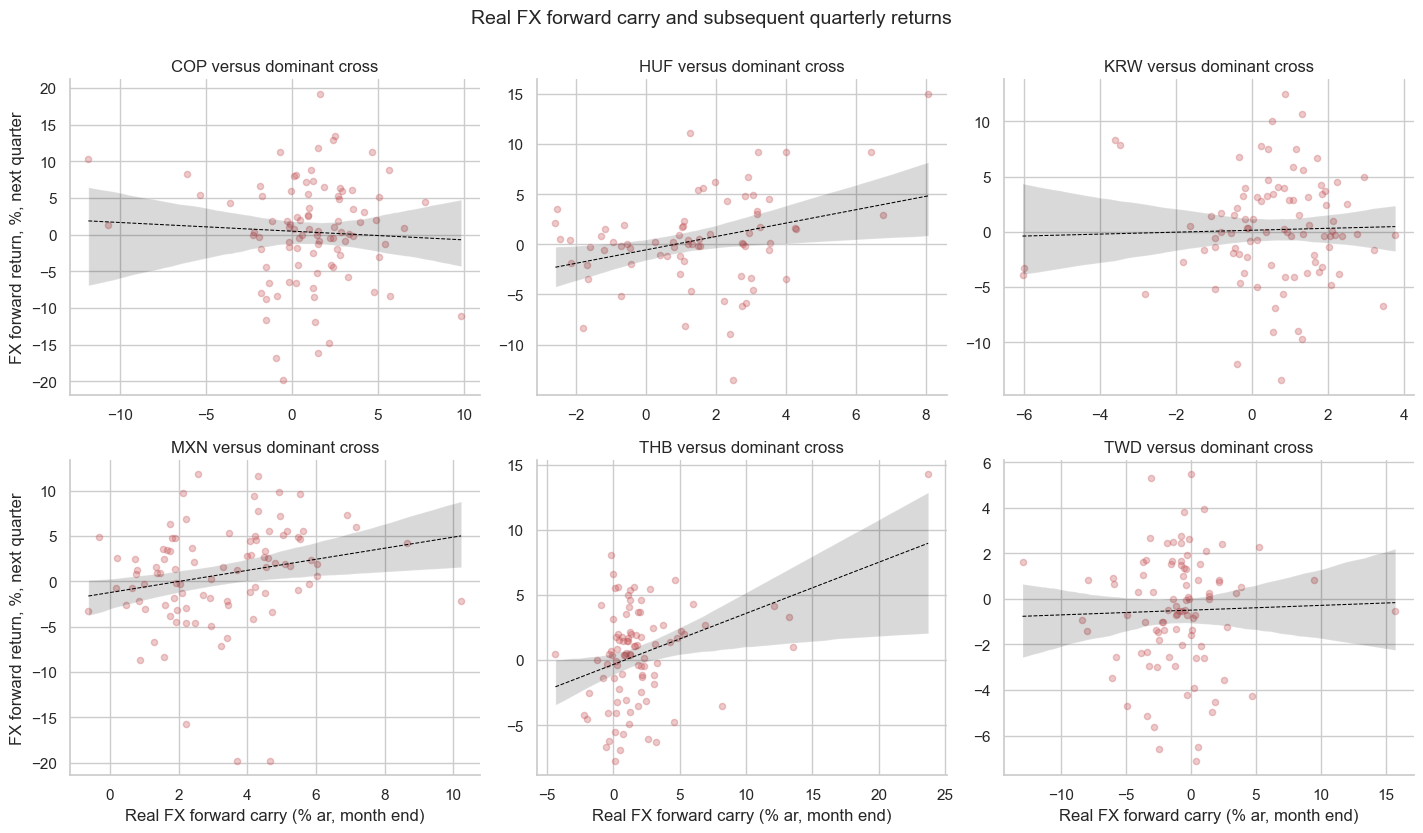

In [ ]:
cids_sel = ['COP', 'HUF', 'KRW', 'MXN', 'THB', 'TWD']  # select cross-sections
xcats_sel = ['FXCRR_NSA', 'FXXR_NSA']  # select explanatory/dependent categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
filt4 = dfx['xcat']==xcats_sel[0]  # filter for features
filt5 = dfx['xcat']==xcats_sel[1] # filter for labels
dff1 = dfx[filt4].groupby(['cid', 'xcat']).resample('Q', on='real_date').last()['value'].reset_index()  # quarterly features
dff2 = dfx[filt5].groupby(['cid', 'xcat']).resample('Q', on='real_date').sum()['value'].reset_index()  # quarterly labels
dff = pd.concat([dff1, dff2])  # re-stack features and labels
filt6 = dff['xcat']==xcats_sel[0]  # filter for frequency-transformed features
dff.loc[filt6, 'value'] = dff[filt6].groupby(['cid', 'xcat'])['value'].shift(1)  # lag explanatory values by 1 time period
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe


sns.set_theme(style='whitegrid')  #  choose appearance
fg=sns.lmplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw,  # pass data
              hue='cid', col='cid', col_wrap=3,  # category that determines partition
              aspect=1.2, height=4,  # aspect and height jointly determine shape and size of plots in grid
              truncate=True, sharex=False, sharey=False,  # appearance of regression plots
              line_kws={'color':'black', 'lw':0.75, 'ls':'--'},  # set some aesthetics of line
              scatter_kws={'s': 20, 'alpha': 0.3, 'color':'r'})  # modify appearance

fg.set_titles(col_template='{col_name} versus dominant cross')
fg.set_axis_labels('Real FX forward carry (% ar, month end)', 'FX forward return, %, next quarter')
fg.fig.suptitle('Real FX forward carry and subsequent quarterly returns',    # set grid title 
                y=1.04, fontsize=14)  # position grid heading and set its font size

plt.show()

In [ ]:
display(dfd.head(3))
display(dff.head(3))
display(dfw.head(3))

,real_date,cid,xcat,value,grading,eop_lag,mop_lag,ticker
0,2000-01-03,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,95.0,292.0,AUD_CPIC_SA_P1M1ML12
1,2000-01-03,AUD,CPIC_SJA_P3M3ML3AR,3.006383,2.0,95.0,186.0,AUD_CPIC_SJA_P3M3ML3AR
2,2000-01-03,AUD,CPIC_SJA_P6M6ML6AR,1.428580,2.0,95.0,277.0,AUD_CPIC_SJA_P6M6ML6AR


,cid,xcat,real_date,value
0,COP,FXCRR_NSA,2000-03-31,NaN
1,COP,FXCRR_NSA,2000-06-30,1.299907
2,COP,FXCRR_NSA,2000-09-30,1.529378


xcat,cid,real_date,FXCRR_NSA,FXXR_NSA
0,COP,2000-03-31,NaN,-1.683166
1,COP,2000-06-30,1.299907,-8.464718
2,COP,2000-09-30,1.529378,0.533464


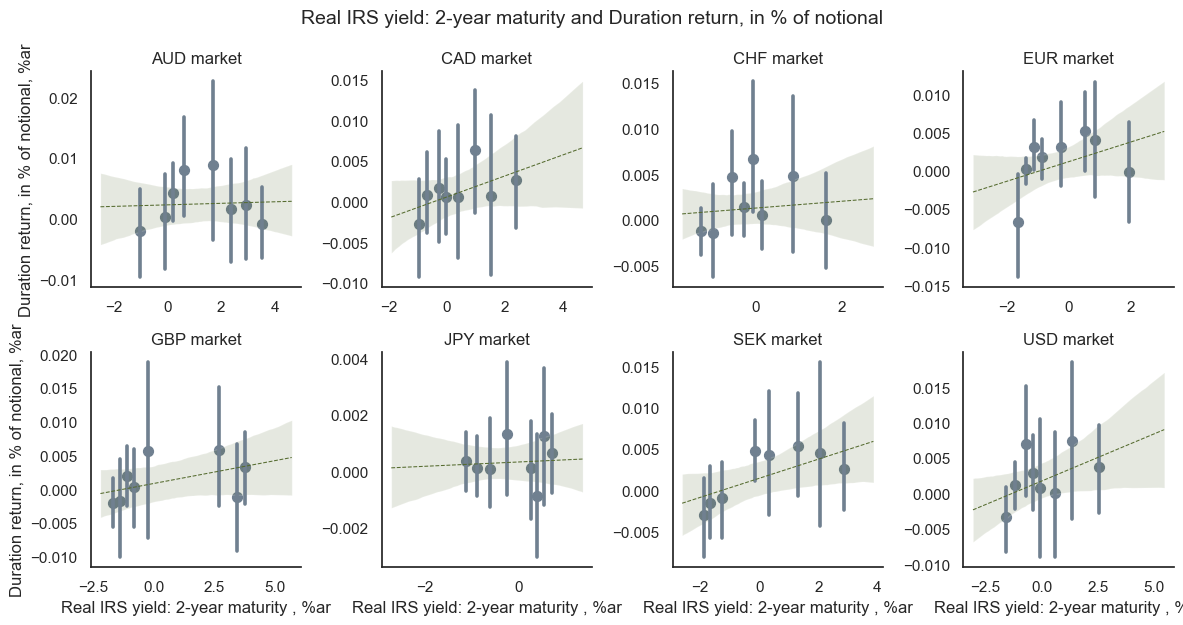

In [ ]:
cids_sel = ['AUD', 'CHF', 'CAD', 'EUR', 'GBP', 'JPY', 'SEK', 'USD']  # select cross-sections
xcats_sel = ['RYLDIRS02Y_NSA', 'DU02YXR_NSA']  # select explanatory/dependent categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
filt4 = dfx['xcat']==xcats_sel[0]  # filter for features
filt5 = dfx['xcat']==xcats_sel[1] # filter for labels
dff = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').mean()['value'].reset_index()  # monthly averages
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe


sns.set_theme(style='white')  #  choose appearance
fg=sns.lmplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw,  # pass data
              hue='cid', col='cid', col_wrap=4,  # category that determines partition
              aspect=1, height=3,  # aspect and height jointly determine shape and size of plots in grid
              x_bins=8,
              truncate=True, sharex=False, sharey=False,  # appearance of regression plots
              line_kws={'color':'darkolivegreen', 'lw':0.75, 'ls':'--'},  # set some aesthetics of line
              scatter_kws={'color':'slategray'})  # modify appearance

fg.set_titles(col_template='{col_name} market')
fg.set_axis_labels('Real IRS yield: 2-year maturity , %ar', 'Duration return, in % of notional, %ar')
fg.fig.suptitle('Real IRS yield: 2-year maturity and Duration return, in % of notional',    # set grid title 
                y=1.04, fontsize=14)  # position grid heading and set its font size

plt.show()

### Jointplots

The jointplot shows simultaneously the relation between two variables and their distributions. It consists of three separate plots: a relational plot and two histograms. Technically it is a facet grid. It is managed through the `sns.jointplot()` function.

Importantly, one can choose from a range of relational plots through the `kind` argument.

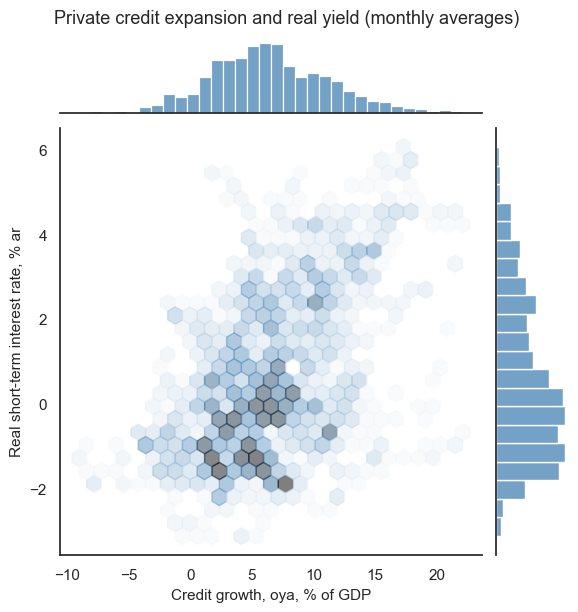

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'NZD', 'SEK', 'USD']  # select cross-sections
xcats_sel = ['PCREDITGDP_SJA_D1M1ML12', 'RYLDIRS02Y_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').mean()['value'].reset_index()  # weekly averages
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

sns.set_theme(style='white', rc={'figure.figsize':(6, 4)})  #  choose appearance
fg = sns.jointplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw, color='steelblue',
                   kind='hex', alpha=0.5)  # display density in hexgons
fg.fig.suptitle('Private credit expansion and real yield (monthly averages)', y=1.02, fontsize=13)  # set grid title
fg.set_axis_labels('Credit growth, oya, % of GDP', 'Real short-term interest rate, % ar', fontsize=11)  # set x/y axis labels

plt.show()

A regression line can be added by applying the `plot_joint()` method to the joint plot facegrid.

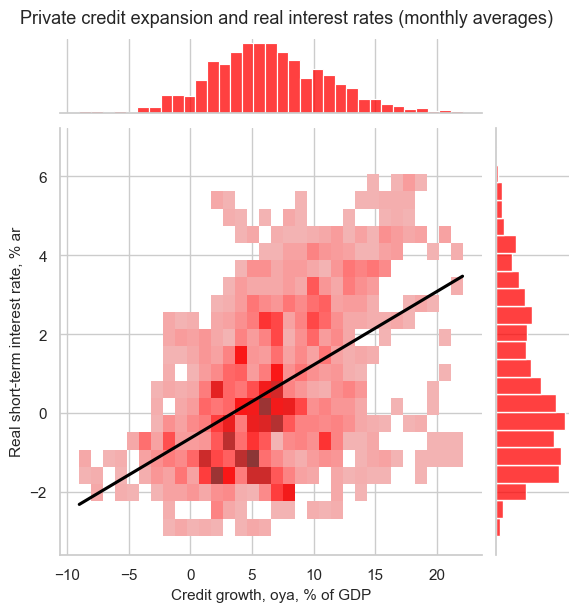

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'NZD', 'SEK', 'USD']  # select cross-sections
xcats_sel = ['PCREDITGDP_SJA_D1M1ML12', 'RYLDIRS02Y_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').mean()['value'].reset_index()  # weekly averages
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

sns.set_theme(style='whitegrid', rc={'figure.figsize':(6, 4)})  #  choose appearance
fg = sns.jointplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw, kind='hist',  #  choose 2-dimension histogram
                   color='red')
fg.plot_joint(sns.regplot, scatter=False, ci=False, color='black')  # one can overlay regression line
fg.fig.suptitle('Private credit expansion and real interest rates (monthly averages)', y=1.02, fontsize=13)  # set grid title
fg.set_axis_labels('Credit growth, oya, % of GDP', 'Real short-term interest rate, % ar', fontsize=11)  # set x/y axis labels

plt.show()

The kernel density estimator (`kind='kde'`) gives a very stylized visualization of the relations.

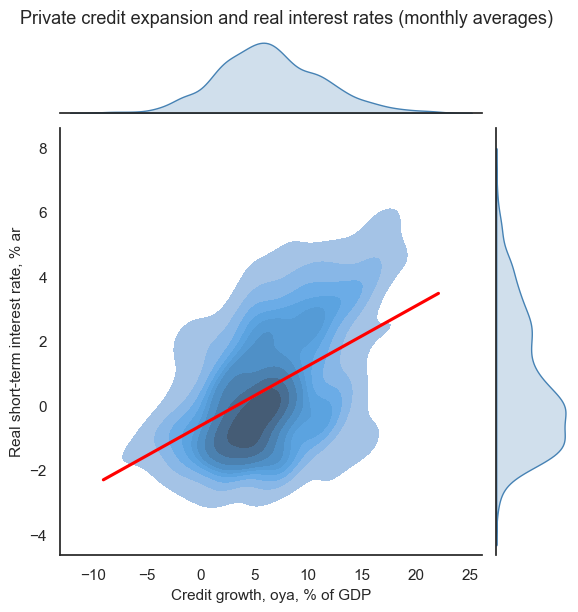

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'NZD', 'SEK', 'USD']  # select cross-sections
xcats_sel = ['PCREDITGDP_SJA_D1M1ML12', 'RYLDIRS02Y_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').mean()['value'].reset_index()  # weekly averages
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

sns.set_theme(style='white')  #  choose appearance
fg = sns.jointplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw, kind='kde',
                   joint_kws={'fill': True},  # keyword dictionary specific to relational plot
                   color='steelblue', height=6)  # color and size parameters
fg.plot_joint(sns.regplot, scatter=False, ci=False, color='red')  # one can overlay regression line
fg.fig.suptitle('Private credit expansion and real interest rates (monthly averages)', y=1.02, fontsize=13)  # set grid title
fg.set_axis_labels('Credit growth, oya, % of GDP', 'Real short-term interest rate, % ar', fontsize=11)  # set x/y axis labels

plt.show()

Information of categorical variables can be integrated through the `hue` argument.

Additional arguments can be passed to the central relational and marginal distribution plots through the `joint_kws` and `marginal_kw` keyword dictionaries respectively.

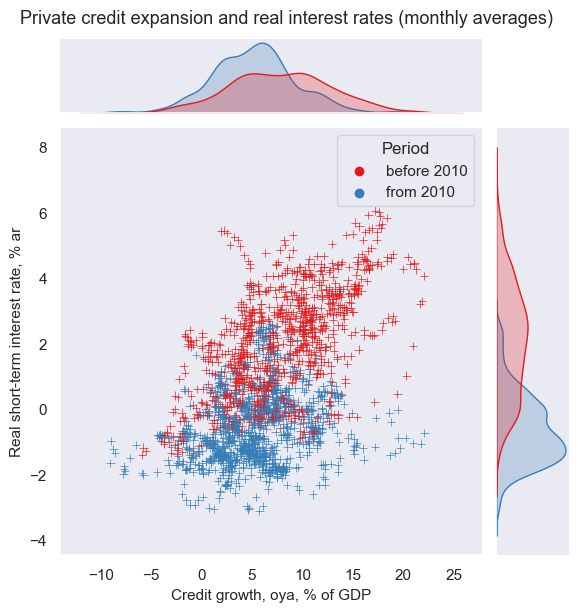

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'NZD', 'SEK', 'USD']  # select cross-sections
xcats_sel = ['PCREDITGDP_SJA_D1M1ML12', 'RYLDIRS02Y_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').mean()['value'].reset_index()  # weekly averages
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

dfw['Period'] = 'before 2010'  # create custom categorical variable
dfw.loc[dfw['real_date'].dt.year > 2010, 'Period'] = 'from 2010'

colors='Set1'  # choose color palette
sns.set_theme(style='dark')  #  choose appearance
fg = sns.jointplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw,  # pass appropriate data
                   kind='scatter', palette=colors, height=6,  # parameters for appearance
                   hue='Period',  # classes of pepriod category will be visualized by hue
                   joint_kws={'marker':'+'},  # keyword dictionary specific to relational plot
                   marginal_kws={'lw': 1})  # keyword dictionary specific to distribution plot
fg.fig.suptitle('Private credit expansion and real interest rates (monthly averages)', y=1.02, fontsize=13)  # set grid title
fg.set_axis_labels('Credit growth, oya, % of GDP', 'Real short-term interest rate, % ar', fontsize=11)  # set x/y axis labels

plt.show()

The choice of the kernel density estimator can make the influence of the background categorical factor on correlation and distribution more transparent.

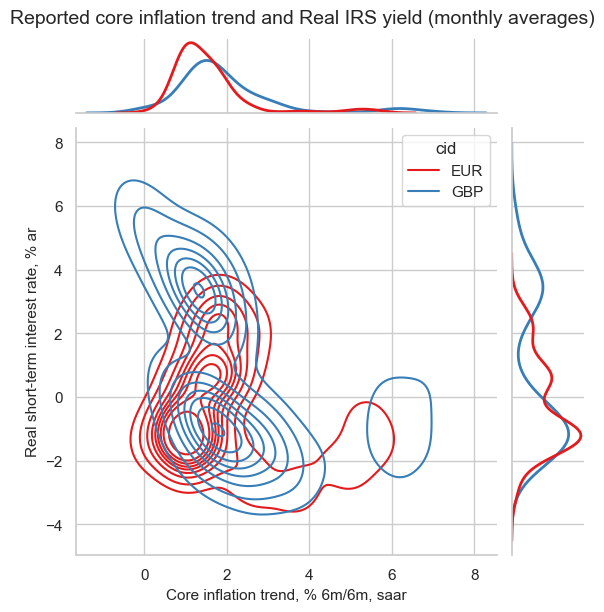

In [ ]:
cids_sel = ['EUR', 'GBP']  # select cross-sections
xcats_sel = ['CPIC_SA_P1M1ML12', 'RYLDIRS02Y_NSA']  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('M', on='real_date').mean()['value'].reset_index()  # weekly averages

dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

colors='Set1'  # choose color palette
sns.set_theme(style='whitegrid')  #  choose appearance
fg = sns.jointplot(x=xcats_sel[0], y=xcats_sel[1], data=dfw,  # pass appropriate data
                   kind='kde', palette=colors, height=6,  # parameters for appearance
                   hue='cid',  # classes of pepriod category will be visualized by hue
                   marginal_kws={'lw': 2})  # keyword dictionary specific to distribution plot
fg.fig.suptitle('Reported core inflation trend and Real IRS yield (monthly averages)', y=1.02, fontsize=14)  # set grid title
fg.set_axis_labels('Core inflation trend, % 6m/6m, saar', 'Real short-term interest rate, % ar', fontsize=11)  # set x/y axis labels

plt.show()

### Pairplots

The `sns.pairplot()` function manages the display of multiple joint distributions. For example, it can be applied to visualize the joint density of a category across pairs of countries. Specifically, the pairplot is  a joint visualization grid of univaraiate distributions on the diagonals and bivariate distributions on the off-diagonals. <u>It collects a lot of information in one place and is therefore an instance of comprehensive exploratory data analysis</u>. 
The `sns.pairplot()` output is a `PairGrid` instance, similar to a facet grid. rather than a single axes object.

Many arguments of `sns.pairplot` apply either to all diagonals or all off-diagonals:
* `kind` governs the type of off-diagonal relational plot to use. It must be one of `scatter`, `kde`, `hist`, or `reg`.
* `plot_kws` takes a dictionary of further arguments that apply to the chosen off-diagonal (main) plots.
* `diag_kind` governs the type of diagonal plot to use and is usually `hist` or `kde`.
* `diag_kws` takes a dictionary of arguments that apply to the chosen diagonal plots.

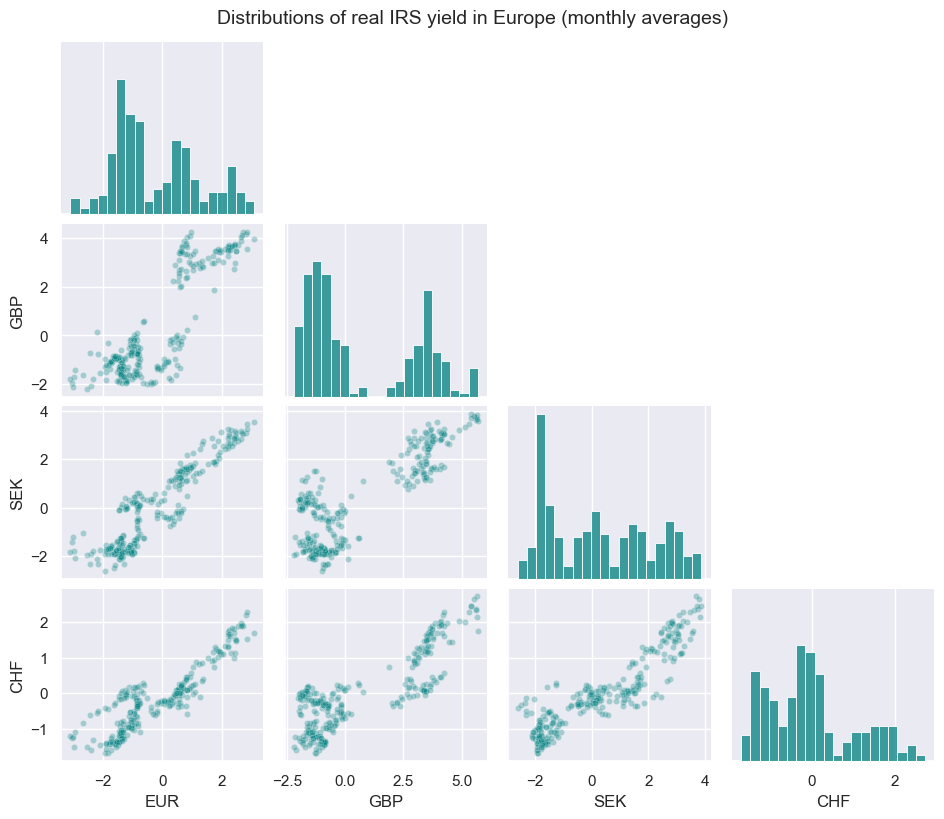

In [ ]:
cids_sel = ['EUR', 'GBP', 'SEK', 'CHF']  # select cross-sections
xcat_sel = 'RYLDIRS02Y_NSA' # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'] == xcat_sel  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid']).resample('M', on='real_date').mean()['value'].reset_index()  # monthly averages
dfw = dff.pivot(index='real_date', columns='cid', values='value').reset_index()  # pivot to wide dataframe
dfw = dfw[(dfw.T != 0).any()]  # drop all rows that are all zeroes

color = 'teal'  # choose palette
sns.set_theme(style='darkgrid')  #  choose appearance
fg=sns.pairplot(data=dfw, vars=cids_sel, 
                height=2, aspect=1.2,  # height and aspect ratio of each facet in the plot
                corner=True,  # removes redundant bivariate plots in symmetric matrix
                kind='scatter',  # choose type of bivariate plot
                plot_kws={'s':20, 'alpha':0.3, 'color':color},  # set parameters for off-diagonal plots
                diag_kind='hist',  # choose type of univariate distribution plot
                diag_kws={'bins':20, 'color':color})  # set parameters for off-diagonal plots)
fg.fig.suptitle('Distributions of real IRS yield in Europe (monthly averages)', y=1.02, fontsize=14)  # set grid title

plt.show()

In order to apply the `sns.pairplot()` function to cross-sections one had to pivot the selected dataframe with cross-sections ('cid') as basis for new columns. In order to apply the `sns.pairplot()` function to categories one simply needs to pivot the selected dataframe with cross-sections ('xcat') as basis for new columns.

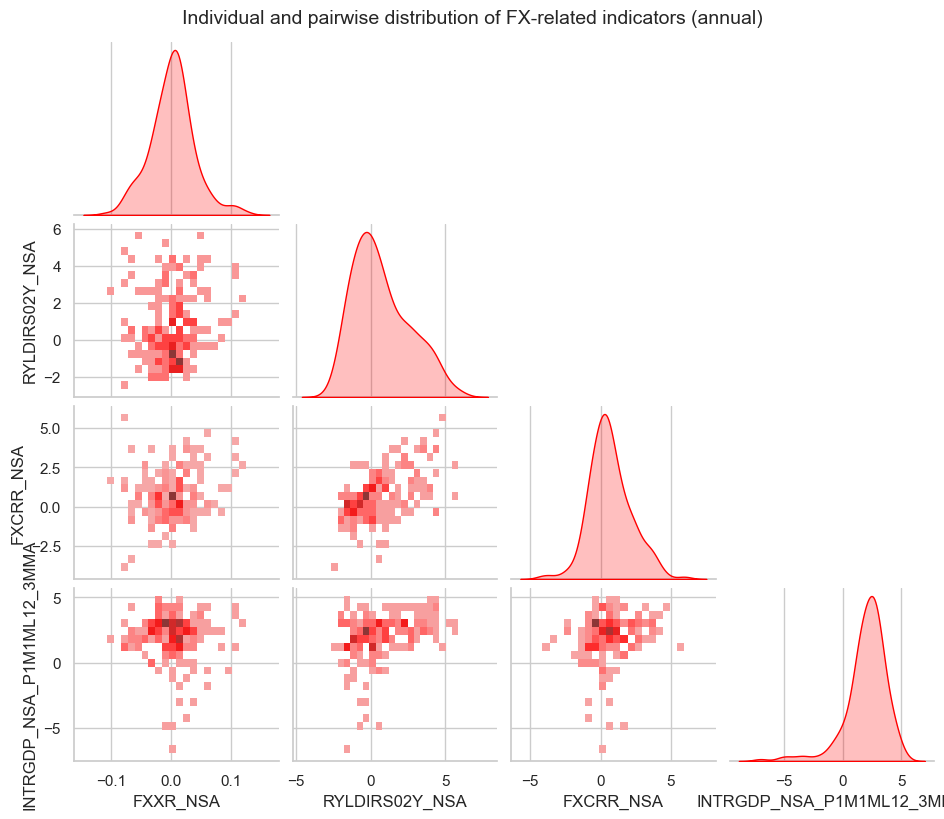

In [ ]:
cids_sel = ['AUD', 'CAD', 'CHF', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK']  # select cross-sections
xcats_sel = ['FXXR_NSA', 'RYLDIRS02Y_NSA', 'FXCRR_NSA', 'INTRGDP_NSA_P1M1ML12_3MMA'] # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'].isin(xcats_sel)  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid', 'xcat']).resample('A', on='real_date').mean()['value'].reset_index()  # annual averages
dfw = dff.pivot(index=['cid', 'real_date'], columns='xcat', values='value').reset_index()  # pivot to wide dataframe

color = 'red'  # choose palette
sns.set_theme(style='whitegrid', palette=colors)  #  choose appearance
fg=sns.pairplot(data=dfw, vars=xcats_sel, 
                height=2, aspect=1.2,  # height and aspect ratio of each facet in the plot
                corner=True,  # removes redundant bivariate plots in symmetric matrix
                plot_kws={'color': color, 'bins':20},  # set parameters for off-diagonal plots
                kind='hist',  # choose type of bivariate plot
                diag_kind='kde',  # choose type of univariate distribution plot
                diag_kws={'color':color})  # set parameters for off-diagonal plots)
fg.fig.suptitle('Individual and pairwise distribution of FX-related indicators (annual)', 
                y=1.02, fontsize=14)  # set grid title
plt.show()

Adding even more information, the pairplot can show distributions and relations for separate values of a categorical variable, using the `hue` argument and a related `palette` choice.

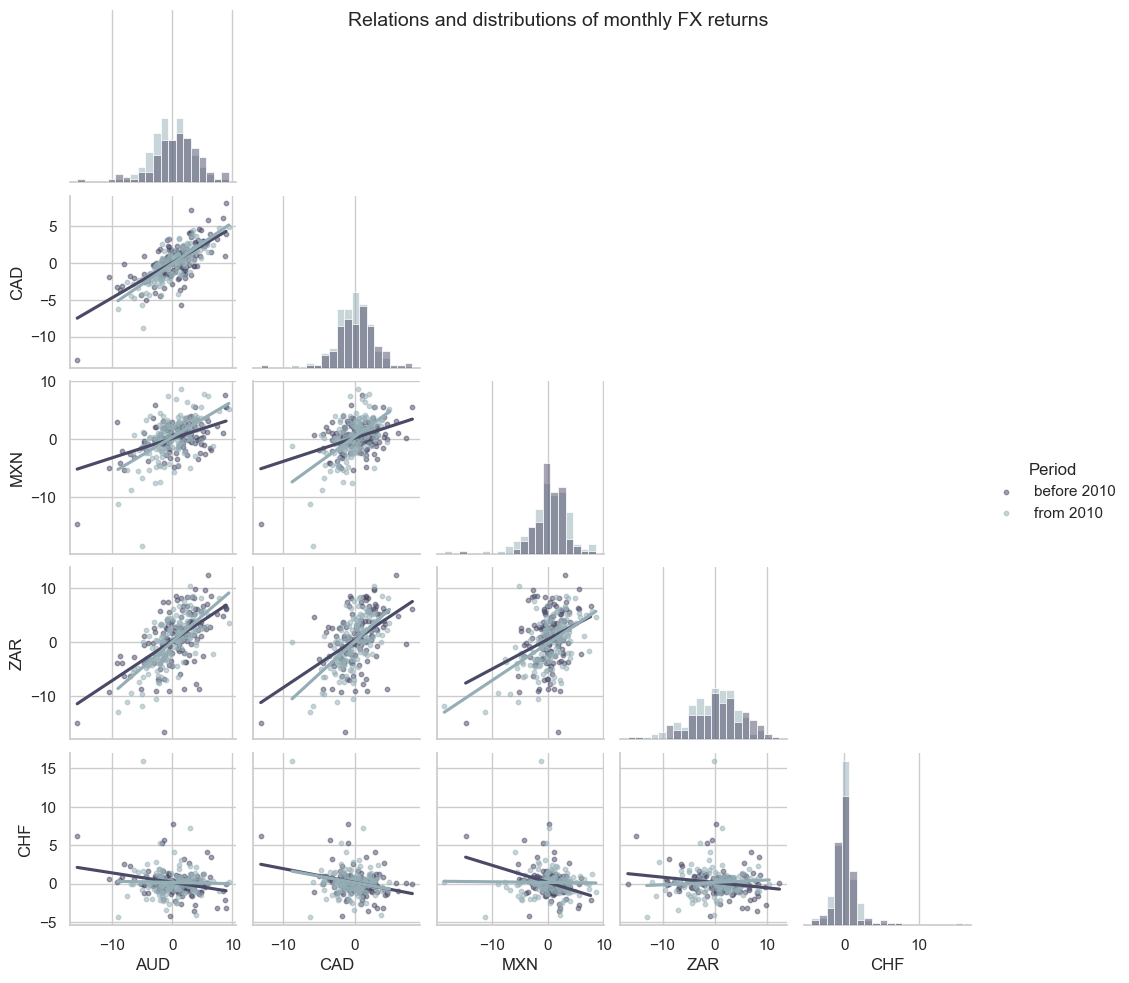

In [ ]:
cids_sel = ['AUD', 'CAD', 'MXN', 'ZAR', 'CHF']  # select cross-sections
xcat_sel = 'FXXR_NSA' # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'] == xcat_sel  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dff = dfx.groupby(['cid']).resample('M', on='real_date').sum()['value'].reset_index()  # monthly sums
dfw = dff.pivot(index='real_date', columns='cid', values='value').reset_index()  # pivot to wide dataframe

dfw['Period'] = 'before 2010'  # create custom categorical variable
dfw.loc[dfw['real_date'].dt.year > 2010, 'Period'] = 'from 2010'

colors = 'bone'  # choose palette
sns.set_theme(style='whitegrid')  #  choose appearance
fg=sns.pairplot(data=dfw, vars=cids_sel, palette=colors, hue='Period',  #  apply classification variable to hue
                height=2, aspect=1,  # height and aspect ratio of each facet in the plot
                corner=True,  # removes redundant bivariate plots in symmetric matrix
                kind='reg',  # choose the type of bivariate plot
                plot_kws={'ci': False, 'scatter_kws':{'s': 10, 'alpha': 0.5}},  # set parameters for off-diagonal plots
                diag_kind='hist',  # choose type of univariate distribution plot
                diag_kws={'bins':20})  # set parameters for off-diagonal plots)
fg.fig.suptitle('Relations and distributions of monthly FX returns', fontsize=14)  # set grid title

plt.show()

# Color maps

### Heatmaps

Heatmaps visualize tabular data by mapping numeric values to colors. They are managed by the `sns.heatmap()` function. This is a particularly powerful method for condensing a lot of information into a single visualization.

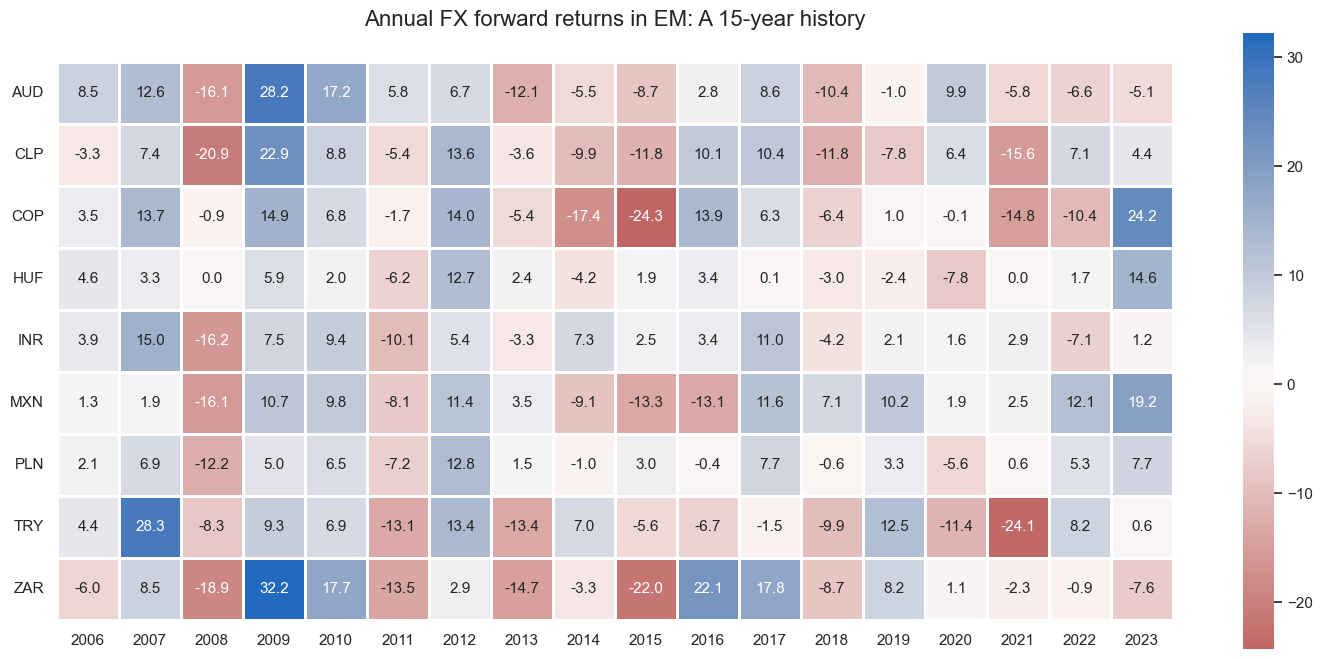

In [ ]:
cids_sel = ['AUD', 'BRL', 'COP', 'CLP', 'HUF', 'MXN', 'PLN', 'TRY', 'ZAR', 'INR', 'MYR', 'PHP']  # select cross-sections
xcat_sel = 'FXXR_NSA' # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'] == xcat_sel  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2006-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dfx['year'] = dfx['real_date'].dt.year  #  # add year category to frame
dfw = dfx.groupby(['cid', 'year']).sum(numeric_only="True").reset_index().pivot(index='year', columns='cid', values='value')
dfh = dfw.T  # transpose to appropriate format for heatmap function

colors = 'vlag_r' # choose appropriate diverging color palette
fg, ax = plt.subplots(figsize=(18, 8))  # prepare axis and grid
ax = sns.heatmap(dfh, cmap=colors, center=0,  # requires diverging color palette with white zero
                 square=True,  # perfect squares
                 annot=True, fmt='.1f', annot_kws={'fontsize':11},  # format annotation numbers inside color boxes
                 linewidth=1)  # set width of lines between color boxes

plt.title('Annual FX forward returns in EM: A 15-year history', fontsize=16, y=1.05)  # set heatmap title
plt.xlabel('')  # control x-axis label
plt.ylabel('')  # control x-axis label
plt.yticks(rotation=0)  # set direction of y-axis marks
plt.show()

### Cross correlations



The easiest way to display correlations across a range of sections is to pass a correlation matrix, created by applying the `.corr()` method to a wide cross 'section x observations' dataframe, to the `sns.heatmap()` function. The color coding does all the work of visualization.

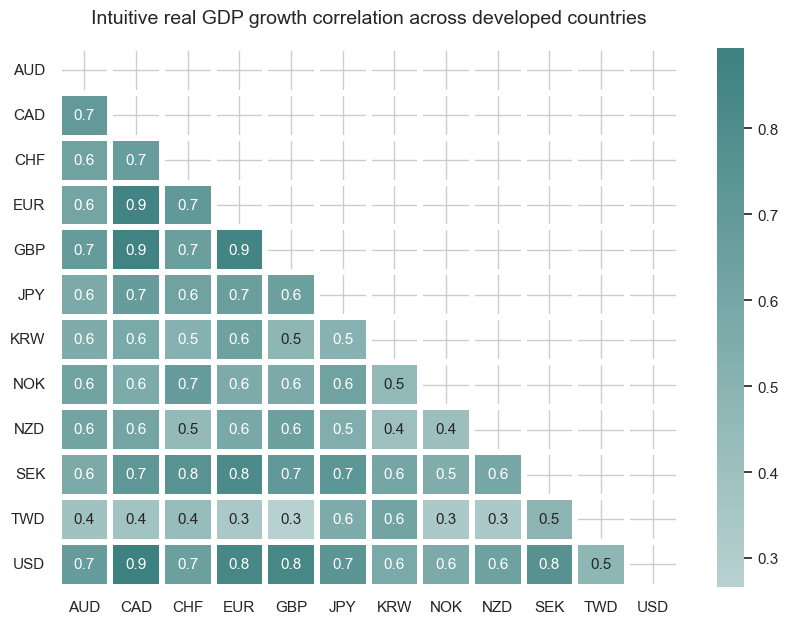

In [ ]:
cids_sel = cids_dm + ['KRW', 'TWD']  # select cross-sections
xcat_sel = 'INTRGDP_NSA_P1M1ML12_3MMA'  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'] == xcat_sel  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd.loc[filt1 & filt2 & filt3, ['cid', 'real_date', 'value']]  # filter out relevant data frame
dfw = dfx.pivot(index=['real_date'], columns='cid', values='value')  # pivot out to date index and cross-section columns

csquare = dfw.corr()  # cross-correlation matrix
mask = np.triu(np.ones_like(csquare, dtype=bool), k=0)  # mask for reundant upper triangle

colors = sns.diverging_palette(20, 190, as_cmap=True) # customize diverging color palette
fg, ax = plt.subplots(figsize=(10, 7))  # prepare axis and grid

ax = sns.heatmap(csquare, cmap=colors, center=0,  # requires diverging color palette with white zero
                 annot=True, fmt='.1f', annot_kws={'fontsize':11},  # format annotation numbers inside color boxes
                 mask = mask,  # remove redundant upper triangle
                 linewidth=3)  # set width of lines between color boxes

plt.title('Intuitive real GDP growth correlation across developed countries', 
          fontsize=14, y=1.03)  # set heatmap title
plt.xlabel('')  # control x-axis label
plt.ylabel('')  # control x-axis label
plt.yticks(rotation=0)  # set direction of y-axis marks
plt.show()

A less common means of visualization cross correlations is the `sns.replot()` function. It is an interface for drawing relational plots onto a `FacetGrid`. It is mostly used for displaying bivariate relations, but can also produced a color- and size-coded display of correlation coefficients across multiple sections.

The below graph allows the greater focus on higher correlation coefficients (whether positive or negative) and can be a better visualization for a large number of cross-sections with very diverse relations.

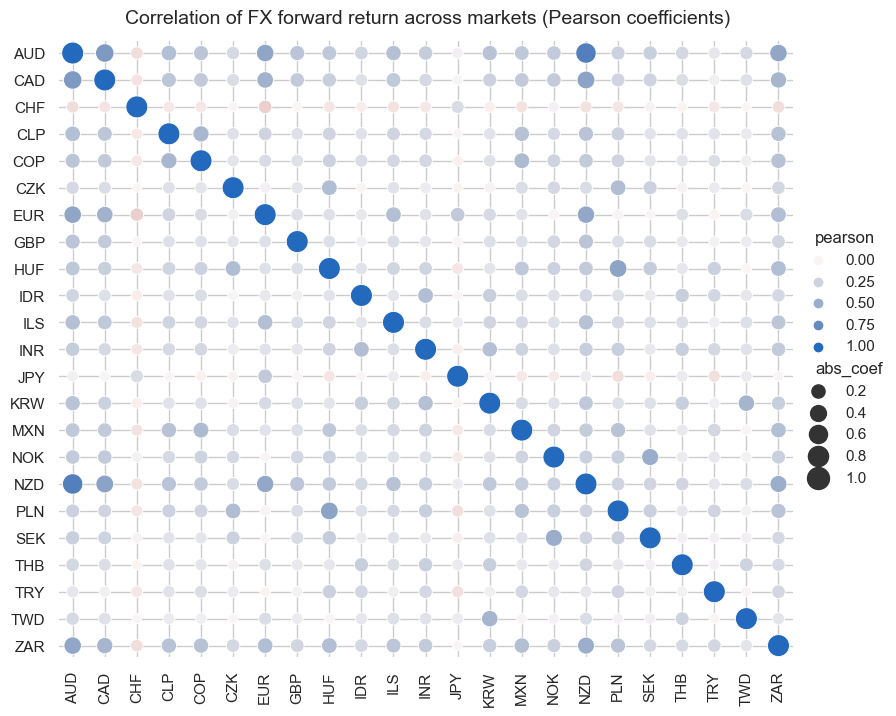

In [ ]:
cids_sel = cids  # select cross-sections
xcat_sel = 'FXXR_NSA'  # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'] == xcat_sel  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2000-01-01')  # filter for start date
dfx = dfd.loc[filt1 & filt2 & filt3, ['cid', 'real_date', 'value']]  # filter out relevant data frame
dfw = dfx.pivot(index=['real_date'], columns='cid', values='value')  # pivot out to date index and cross-section columns

csquare = dfw.corr()  # square correlation coefficient dataframe across all columns
csquare.index.rename('cid0', inplace=True)  # rename index name to allow unstacking
dfc = csquare.unstack().reset_index()  # unstack to long-dataframe
dfc.rename(mapper={0: 'pearson'}, axis=1, inplace=True)  # give intuitive name to correlation value column
dfc['abs_coef'] = np.abs(dfc['pearson'])  # add column of absolute coefficient values (for size)

sns.set_theme(style='whitegrid')  
fg = sns.relplot(
    data=dfc, x="cid", y="cid0",  # define axes
    hue="pearson", hue_norm=(-1, 1), palette="vlag_r",  # color code correlation coefficients
    size="abs_coef", size_norm=(0, 1), sizes=(50, 250),  # express absolute coefficients by size
    height = 7, aspect = 1.2)  # control facet grid shape

fg.fig.suptitle('Correlation of FX forward return across markets (Pearson coefficients)', y=1.02, fontsize=14)  # set grid title
fg.set(xlabel="", ylabel="")  # remove axes labels
fg.despine(left=True, bottom=True)  # remove axes lines
fg.ax.margins(.02)  # control proximity of labels to axes
for label in fg.ax.get_xticklabels():
    label.set_rotation(90)  # rotate x-tick labels for readability
    
plt.show()

### Clustermaps

The clustermap supports heatmap visualization of matrices with additional hierarchical clustering information.

The clustering lines are called **dendrograms** and display the statistical similarity of columns and rows. Similarity here is the inverse of multi-dimensional distance. The default is Euclidean or spatial distance. The dendrogram is created based on hierarchical agglomerative clustering, i.e. sequential clustering of the nearest points in multi-dimensional space. Note that the `sns.clustermap` method returns a `Clustermap` object.

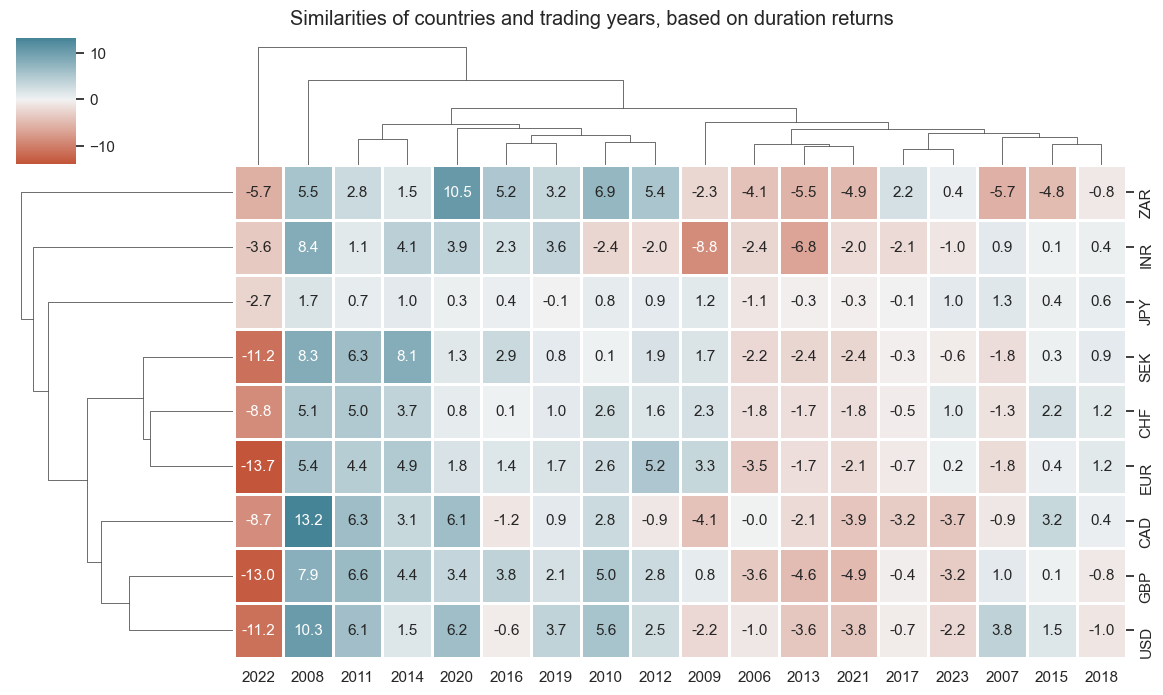

In [ ]:
cids_sel = ['EUR', 'USD', 'GBP', 'CHF', 'JPY', 'SEK', 'CAD',  'ZAR', 'INR', 'MYR']  # select cross-sections
xcat_sel = 'DU05YXR_NSA' # select categories
filt1 = dfd['cid'].isin(cids_sel)  # filter for cross-sections
filt2 = dfd['xcat'] == xcat_sel  #  filter for category
filt3 = dfd['real_date'] >= pd.to_datetime('2005-01-01')  # filter for start date
dfx = dfd[filt1 & filt2 & filt3]  # filter out relevant data frame
dfx['year'] = dfx['real_date'].dt.year  #  # add year category to frame
dfw = dfx.groupby(['cid', 'year']).sum(numeric_only="True").reset_index().pivot(index='year', columns='cid', values='value')  # annual means
dfh = dfw.dropna().T  # transpose to appropriate format for heatmap function

colors = sns.diverging_palette(20, 220, as_cmap=True) # choose appropriate diverging color palette
fg = sns.clustermap(dfh, cmap=colors, center=0,  # requires diverging color palette with white zero
                    figsize=(12, 7),  # set appropriate size
                    annot=True, fmt='.1f', annot_kws={'fontsize':11},  # format annotation numbers inside color boxes
                    linewidth=1)  # set width of lines between color boxes

fg.fig.suptitle('Similarities of countries and trading years, based on duration returns', y=1.02)  # setting title
fg.ax_heatmap.set_xlabel('')  # special way of controlling x-axis label
fg.ax_heatmap.set_ylabel('')  # special way of controlling y-axis label 
plt.show()